# Reporting dashboard
## Transition frequencies


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from IPython.display import display

import src.compute.changelogs as changelogs
import src.compute.developer as developer
from src.compute.utils import Interval
from src.db.utils import SnowflakeWrapper
from src.config import data_root

conn = SnowflakeWrapper.create_snowflake_connection()
sw = SnowflakeWrapper(conn)

def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
figure_size = (10, 8)

First, we need to define an interval in which we will operate:

In [2]:
active_interval: Interval = Interval(
    # fromDate=date(2019, 7, 1), # year, month, day
    # toDate=date(2019, 10, 1),
    fromDate=date(2019, 10, 1), # year, month, day
    toDate=date(2020, 1, 1)
)
print(active_interval)

('2019-10-01', '2020-01-01')


In [3]:
def draw_most_frequent_per_week(all_data: pd.DataFrame, max_by: pd.DataFrame, dimension:str, metric: str = "TotalTransitions", note:  str = ""):
    fig, ax = plt.subplots(figsize=figure_size, dpi= 80, facecolor='w', edgecolor='k')
    max_y = -1
    min_x = 54
    max_x = -1
    for _, row in max_by.iterrows():
        data = all_data[all_data[dimension].isin([row[dimension]])]
        if len(data) == 0:
            continue
        x_data = data["WeekOfYear"]
        min_x = int(min(min_x, min(x_data)))
        max_x = int(max(max_x, max(x_data)))
        y_data = data[metric]
        max_y = max(max(y_data), max_y)
        ax.plot(x_data, y_data, label=row[dimension])
        ax.plot(x_data, y_data, 'ro')
    
    ax.set_xlabel("Week")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Most Frequent by {dimension} {note}")
    # ax.set_yticks(range(0, max_y + 10, 5), minor=False)
    ax.set_xticks(range(min_x, max_x + 1, 1), minor=False)
    cols = int(len(max_by)/2 + 1)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.105), ncol=cols)
    ax.grid()
    fig.savefig(f"{data_root}/figs/most_frequent_{dimension}_{note}.png")
    fig.show()

Number of actions on the given interval

In [4]:
active_cards = changelogs.transition_frequency(sw, interval=active_interval, by_status=False, by_week=False)
print(f"Cards active in the interval {active_interval}: {active_cards['TotalTransitions'][0]}")

print(f"Number of transitions in the interval, by week:")
frequency_week = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_status=False, by_week=True, order="ASC")
# display(frequency_week)

Cards active in the interval ('2019-10-01', '2020-01-01'): 5929
Number of transitions in the interval, by week:


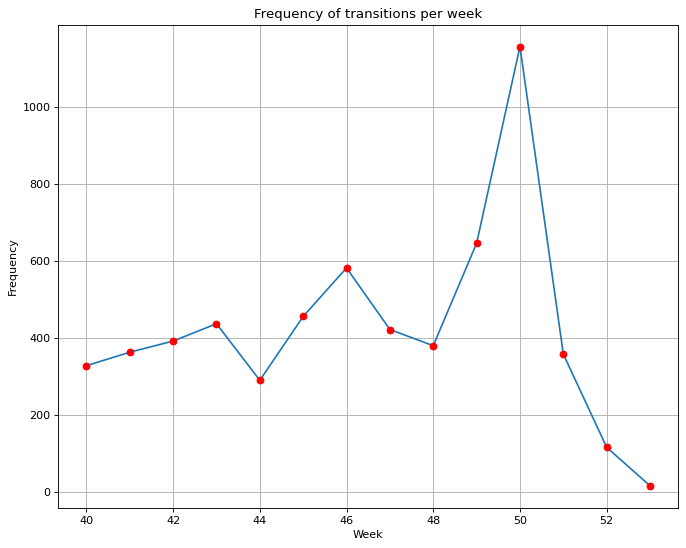

In [5]:
def draw_per_week():
    fig, ax = plt.subplots(figsize=figure_size, dpi= 80, facecolor='w', edgecolor='k')
    ax.set_xlabel("Week")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency of transitions per week")
    ax.grid()
    x_data = frequency_week["WeekOfYear"]
    y_data = frequency_week["TotalTransitions"]
    max_y = max(y_data)
    ax.plot(x_data, y_data)
    ax.plot(x_data, y_data, 'ro')
    ax.set_yticks(range(0, max_y + 10, roundup(int(max_y/10))), minor=False)
draw_per_week()

In [6]:
print(f"Most frequent transitions in the interval:")
most_frequent_transition = changelogs.transition_frequency(sw, interval=active_interval, limit=6, order="DESC")
most_frequent_transition_week = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, order="ASC")
# display(most_frequent_transition)

# print(f"Least frequent transitions in the interval:")
# least_frequent = changelogs.transition_frequency(sw, interval=active_interval, limit=10, order="ASC")
# display(least_frequent)

Most frequent transitions in the interval:


/Users/pr3mar/.local/share/virtualenvs/thesis-cJayiytx/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


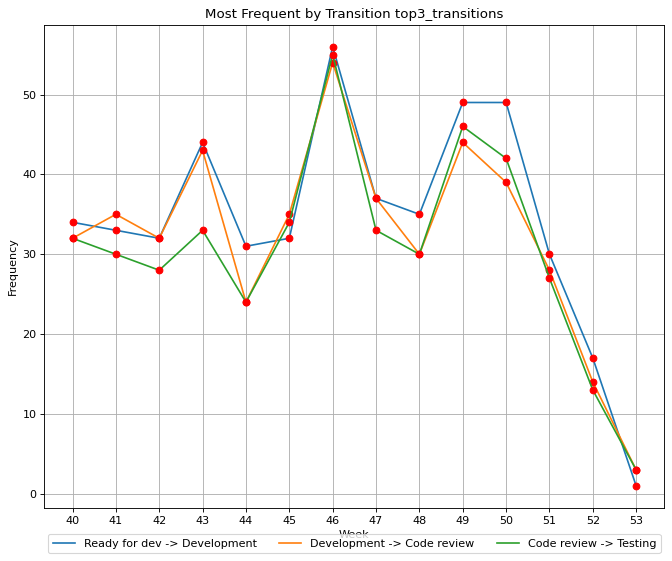

In [7]:
top_transitions = [
    "Ready for dev -> Development",
    "Development -> Code review",
    "Code review -> Needs CR fixes",
    "Code review -> Testing"
]
top_transitions_data = most_frequent_transition_week.loc[most_frequent_transition_week["Transition"].isin(top_transitions)]
draw_most_frequent_per_week(top_transitions_data, most_frequent_transition, "Transition", note="top3_transitions")

/Users/pr3mar/.local/share/virtualenvs/thesis-cJayiytx/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


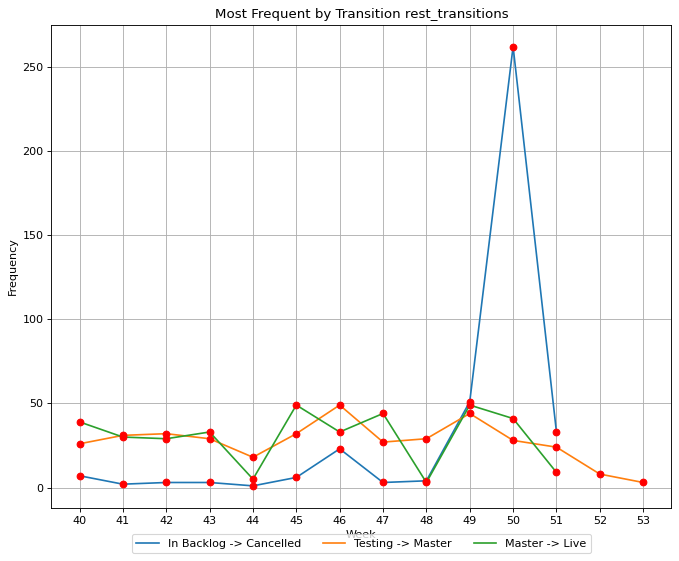

In [8]:
rest_top_transitions_data = most_frequent_transition_week.loc[~most_frequent_transition_week["Transition"].isin(top_transitions)]
draw_most_frequent_per_week(rest_top_transitions_data, most_frequent_transition, "Transition", note="rest_transitions")

In [9]:
most_frequent_type = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=False, by_issue_type=True, by_status=False, order="DESC")
display(most_frequent_type)
most_frequent_week_type = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, by_issue_type=True, by_status=False, order="DESC")
# display(most_frequent_week_type)

,IssueType,TotalTransitions
0,Bug,2103
1,Internal Improvement,1913
2,New Feature or Improvement,1334
3,Task,225
4,Improvement (Sub-task),173
5,Epic,125
6,Sub-task,45
7,Bug (Sub-task),6
8,Prototype,5


/Users/pr3mar/.local/share/virtualenvs/thesis-cJayiytx/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


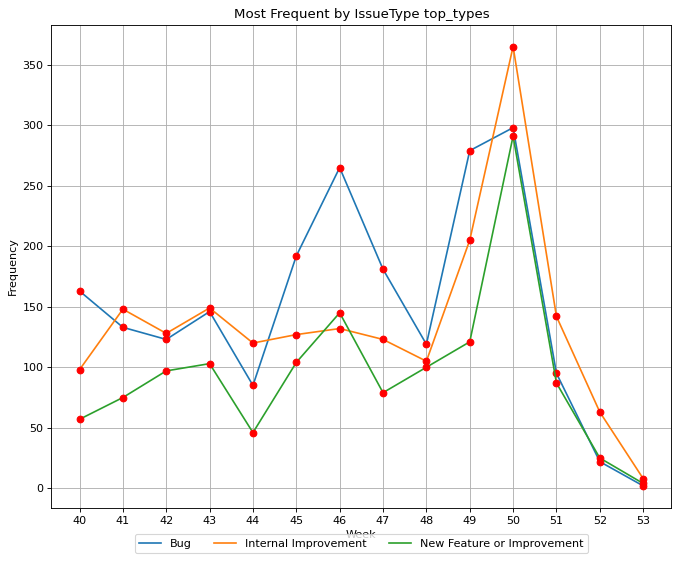

In [10]:
top_types = ["Internal Improvement", "Bug", "New Feature or Improvement"]
top_types_data = most_frequent_week_type.loc[most_frequent_week_type["IssueType"].isin(top_types)]
draw_most_frequent_per_week(top_types_data, most_frequent_type, "IssueType", note="top_types")

/Users/pr3mar/.local/share/virtualenvs/thesis-cJayiytx/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


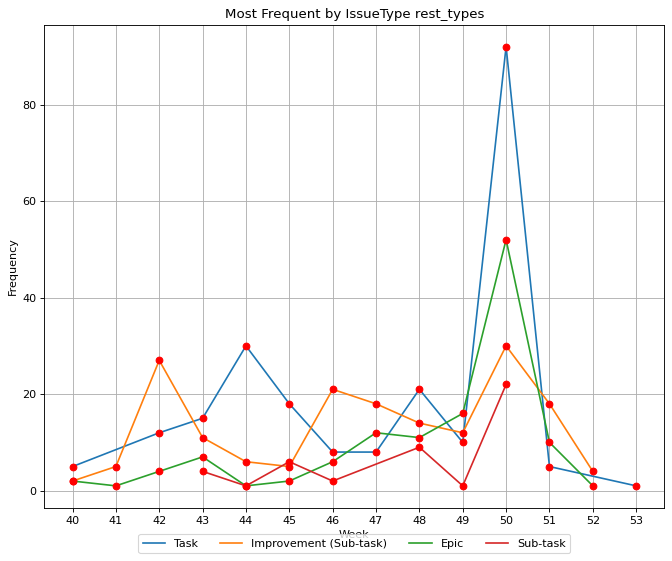

In [11]:
low_types = ["Epic", "Task", "Improvement (Sub-task)", "Sub-task"]
low_types_data = most_frequent_week_type.loc[most_frequent_week_type["IssueType"].isin(low_types)]
draw_most_frequent_per_week(low_types_data, most_frequent_type, "IssueType", note="rest_types")

In [12]:
most_frequent_priority = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=False, by_issue_priority=True, by_issue_type=False, by_status=False, order="DESC")
display(most_frequent_priority)
most_frequent_week_priority = changelogs.transition_frequency(sw, interval=active_interval, limit=-1, by_week=True, by_issue_priority=True, by_issue_type=False, by_status=False, order="DESC")
# display(most_frequent_week_priority)

,IssuePriority,TotalTransitions
0,Minor,2730
1,Major,2388
2,Critical,482
3,Blocker,226
4,Trivial,103


/Users/pr3mar/.local/share/virtualenvs/thesis-cJayiytx/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


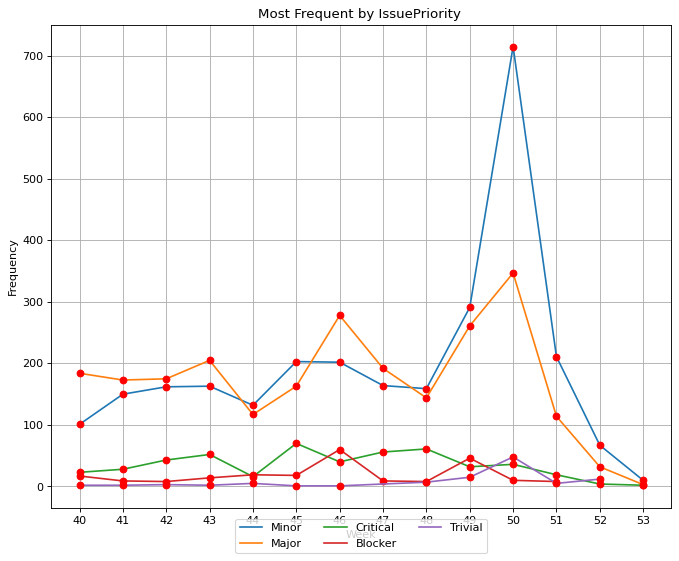

In [13]:
draw_most_frequent_per_week(most_frequent_week_priority, most_frequent_priority, "IssuePriority")

In [14]:
authored_activity = developer.get_avg_authored_activity(sw, active_interval)
display(authored_activity.head(10))
# display(authored_activity.tail(10))

,count,mean,std,min,25%,50%,75%,max
status,106.0,55.933962,74.076186,0.0,2.0,23.5,86.00,336.0
assignee,106.0,29.547170,45.163435,0.0,1.0,14.0,38.50,265.0
description,106.0,25.641509,31.999461,0.0,2.0,12.0,36.00,146.0
labels,106.0,24.320755,34.359596,0.0,1.0,12.5,33.50,184.0
resolution,106.0,13.698113,17.019971,0.0,1.0,9.0,20.00,91.0
Link,106.0,8.830189,16.828814,0.0,0.0,2.0,9.75,123.0
duedate,106.0,4.594340,9.712808,0.0,0.0,0.0,5.75,76.0
Sprint,106.0,4.528302,31.021408,0.0,0.0,0.0,0.00,265.0
Fix Version,106.0,4.462264,29.413044,0.0,0.0,0.0,0.00,284.0
Epic Child,106.0,3.660377,10.046451,0.0,0.0,0.0,2.00,72.0


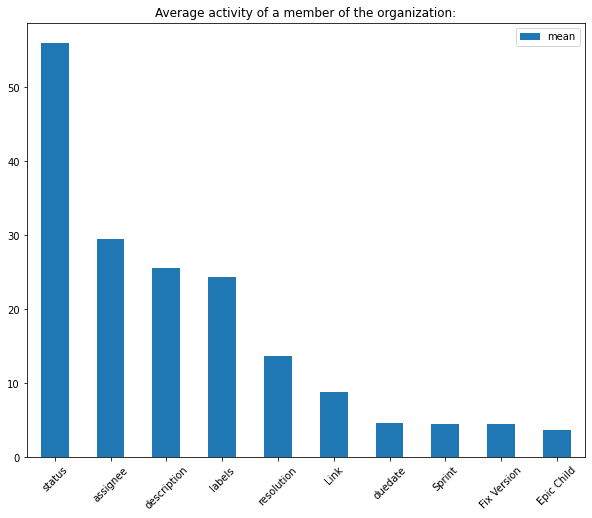

In [15]:
plot = authored_activity.head(10).plot(kind='bar', use_index=True, y='mean', rot=45, figsize=figure_size, title="Average activity of a member of the organization:")
fig = plot.get_figure()
fig.savefig(f"{data_root}/figs/avg_authored_activity.png")